## Gas Station Clusterization in SSA

Escreva aqui uma descrição em alto nível do propósito e funcionamento do código. Ressaltar quais são as entradas e as saídas esperadas.

### 1. Importação de Bicliotecas:

In [5]:
## Imports de bibliotecas
import pandas as pd, numpy as np
import folium as fl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import KMeans
import requests
import json
import time
import os


### 2. Declaração das constantes utilizadas no código:

In [6]:
## Declaração de constantes

# Lista de cores (obs: number of colors MUST be higher than n_clusters)
MYCOLORS = ['maroon','blue','green','orange','red','purple', 'violet', 'brown', 'teal', 'peru']

# arquivos de coordenadas
CSV_LIST = {
    'Barra': 'csv/ssa/gstations_ssa_BARRA.csv', 
    'Pituba': 'csv/ssa/gstations_ssa_PITUBA.csv', 
    'Orla-Leste': 'csv/ssa/gstations_ssa_ORLA_LESTE.csv',
    'SSA': 'csv/ssa/gstations_ssa_SALVADOR.csv'}

# coordenadas do centro de Salvador
MAP_CENTER = [-12.970748228016372, -38.4761939536224]

# número de clusters
NCLUSTERS = 3

### 3. Declaração das funções utilizadas no código:

In [7]:
# Declaração de funções utilizadas no código:
def findClusters(coords, n_clusters=3):
    ''' findClusters
        Agrupa um grupo de coordenadas em 'n_clusters' clusters,
        calculando também a mediana e o indice de cada grupo.
        Entradas:
            coords:     matriz de coordenadas de entrada
            n_clusters: número de clusters desejado (padrão=3)
        Saídas:
            [clusters, clindexes]
            clusters:   conjunto de clusters encontrados
            clindexes:  indice dos clusters encontrados
    '''
    # ajusta as coordenadas em 'n_clusters' grupos (clusters)
    km_coords = KMeans(n_clusters=n_clusters).fit(coords)
    clusters = km_coords.cluster_centers_ # centro de cada cluster
    clindexes = km_coords.predict(coords) # indice de cada cluster
    return clusters, clindexes

def plotClusterCharts(coords, coords_mean,
                      ellipse_mean, clusters, 
                      clindexes, n_clusters=3, 
                      regionName=None):
    ''' plotClusterCharts()
        Plota os centroides e medianas em gráficos 2D.
        Cada cluster é plotado com uma cor diferente
        Entradas:
            coords:         matriz de coordenadas (lat, longi)
            coords_mean:    coordenadas da mediana
            ellipse_mean:   mediana da elipse
            clusters:       clusters
            clindexes:      indice dos clusters (vetor)
        Saídas:
            plot colorido 2D dos clusters
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.scatter(coords[:, 0], coords[:, 1])
    ax1.scatter(coords_mean[0], coords_mean[1], s=200, color = 'purple')
    ax1.add_patch(ellipse_mean)
    ax1.set(title='MEAN AND STANDARD DEVIATION', xlabel='LONGITUDE',ylabel='LATITUDE')
    ax1.text(coords_mean[0], coords_mean[1], 'MEAN')

    # separa os clusters por cor
    for z in range(0,n_clusters):
        dataZ = np.where(clindexes==z)
        newDataX = []
        newDataY = []
        for k in dataZ[0]:
            newDataX.append(coords[k][0])
            newDataY.append(coords[k][1])
        color = MYCOLORS[z] # gets the color for that point
        ax2.scatter(newDataX, newDataY, color=color)

    ax2.scatter(clusters[:,0], clusters[:,1], s=500, color = 'black')
    ax2.set(title='CLUSTERS - nclusters = %d'%(n_clusters), xlabel='LONGITUDE', ylabel='LATITUDE')

    ax1.ticklabel_format(useOffset=False)
    ax2.ticklabel_format(useOffset=False)
    plt.ticklabel_format(style='plain')
    if regionName is not None:
        plt.savefig("tmp/"+regionName+".png")
    plt.show()

def printClusterCoords(clusters, rName):
    ''' printClusterCoords
        Imprime as coordenadas centrais dos clusters
        em uma tabela X/Y
    '''
    print("-----------------------------------------------")
    print("| Clusters para a região: '%s' "%(rName))
    print("-----------------------------------------------")
    print("| Idx  |       Long       |         Lat       |")
    print("-----------------------------------------------")
    cnt=1
    for c in clusters:
        print("| %3d  |  %2.10f  |   %2.10f  |"%(cnt, c[0], c[1]))
        cnt=cnt+1
    print("-----------------------------------------------")

def drawOnMap(mapCenterLat, mapCenterLong, coords, clusters, clindexes,                          n_clusters=3):
    ''' drawOnMap
        Desenha todas as coordenadas e seus respectivos clusters
        em um mapa centralizado em (mapCenterLat, mapCenterLong).
        Cada cluster (e todos os pontos que pertencem a ele) 
        recebe uma cor específica escolhida a partir de seu índice
        Obs: o número de clusters não pode ser maior que comprimento
        da lista de padrão de cores (MYCOLORS)
        Entradas:
            mapCenterLat, mapCenterLong:    centro do mapa;
            coords:                         lista de pontos (lat,long)
            clusters:                       lista de clusters
            clindexes:                      índice dos clusters
            n_clusters:                     número de clusters (padrão = 3)
        Saídas:
            mymap:                          mapa desenhado
    '''
    mymap = fl.Map(location=[mapCenterLat, mapCenterLong], zoom_start=11)
    cnt = 0
    for longi, lat in coords:
        # seleciona a cor do ponto a partir do indice do cluster
        color = MYCOLORS[clindexes[cnt]%n_clusters]
        # cria o marcador
        fl.CircleMarker(location=[lat, longi],
                            radius=10,
                            fill_color=color,
                            color=color,
                            opacity=0.5
                        ).add_to(mymap)
        cnt = cnt+1

    # plota os centroídes
    color = 'black'
    for centroid in clusters:
        longi = centroid[0]
        lat = centroid[1]
        fl.CircleMarker(location=[lat, longi],
                            radius=16,
                            fill_color=color,
                            color=color,
                            opacity=0.9
                        ).add_to(mymap)
   
    return mymap

### 4. Loop principal para identificação dos clusters e cálculo das posições médias:

-----------------------------------------------
| Clusters para a região: 'Barra' 
-----------------------------------------------
| Idx  |       Long       |         Lat       |
-----------------------------------------------
|   1  |  -38.5251578750  |   -12.9949509250  |
|   2  |  -38.5230632889  |   -13.0065964000  |
|   3  |  -38.5149538667  |   -13.0004018000  |
-----------------------------------------------


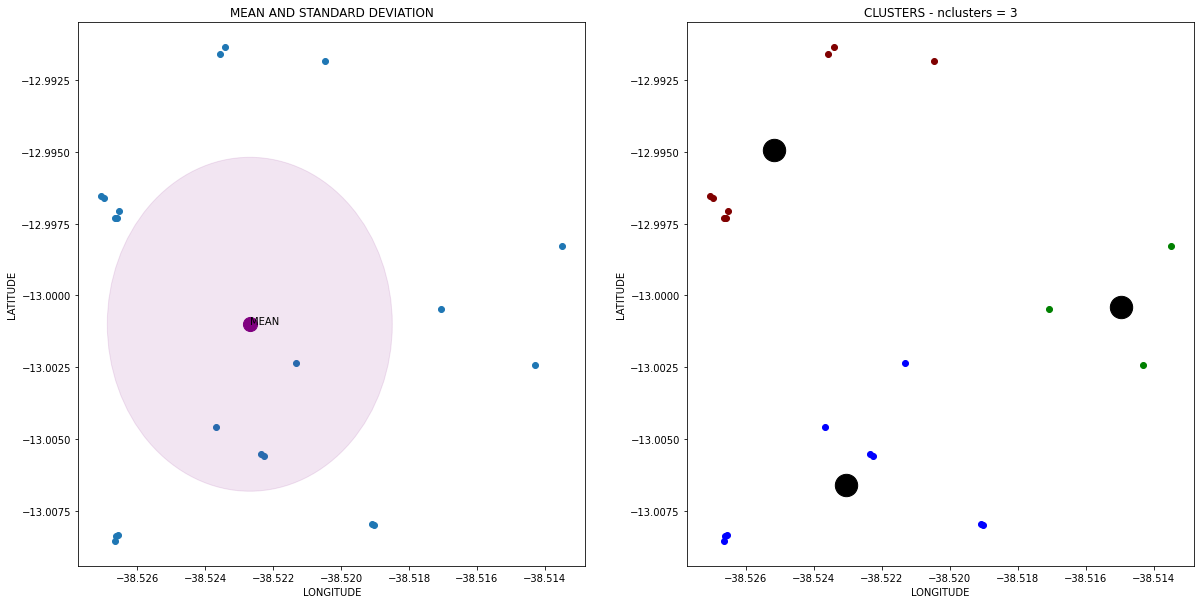

-----------------------------------------------
| Clusters para a região: 'Pituba' 
-----------------------------------------------
| Idx  |       Long       |         Lat       |
-----------------------------------------------
|   1  |  -38.4453348667  |   -12.9899487500  |
|   2  |  -38.4695612625  |   -12.9919682000  |
|   3  |  -38.4643545545  |   -13.0081191273  |
-----------------------------------------------


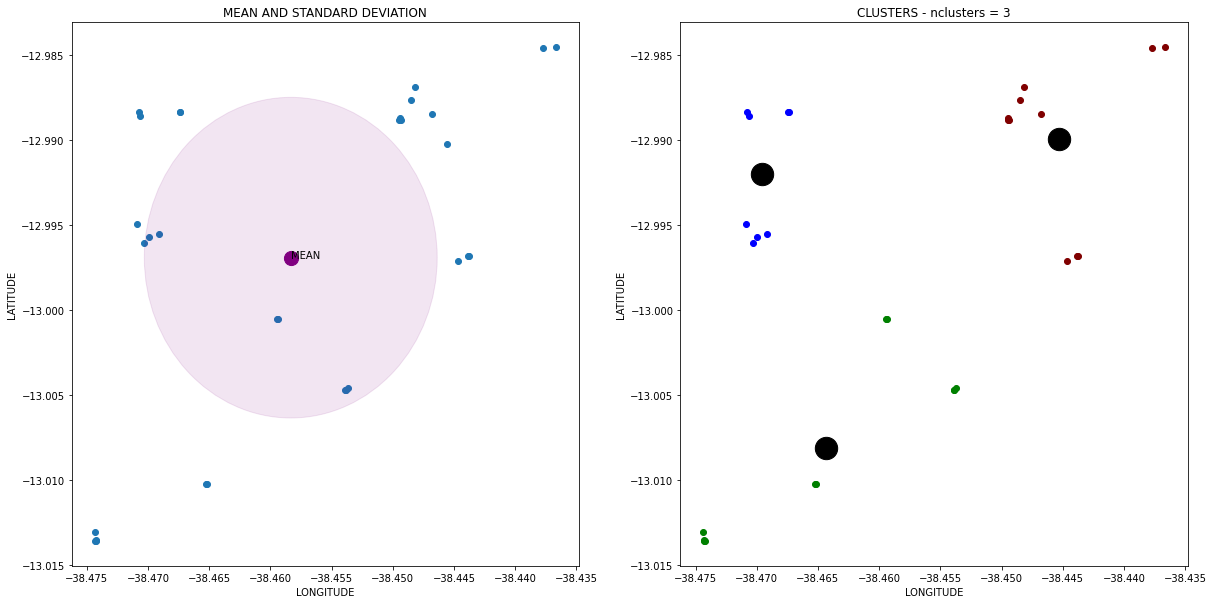

-----------------------------------------------
| Clusters para a região: 'Orla-Leste' 
-----------------------------------------------
| Idx  |       Long       |         Lat       |
-----------------------------------------------
|   1  |  -38.4466002000  |   -12.9815787839  |
|   2  |  -38.3764422944  |   -12.9459232250  |
|   3  |  -38.5015271447  |   -13.0001079974  |
-----------------------------------------------


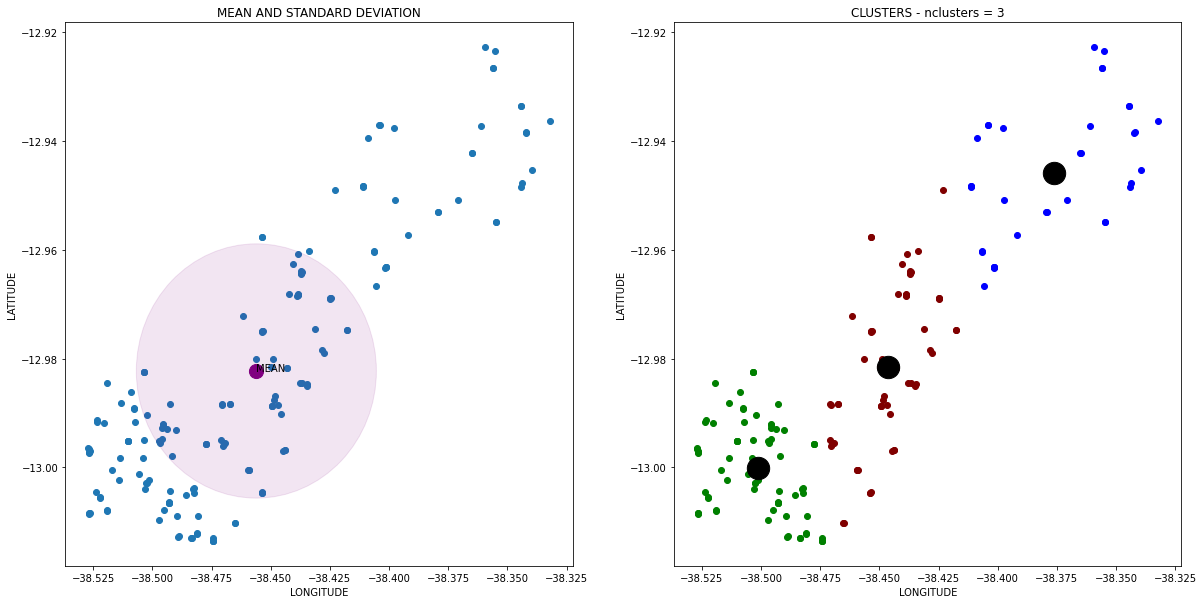

-----------------------------------------------
| Clusters para a região: 'SSA' 
-----------------------------------------------
| Idx  |       Long       |         Lat       |
-----------------------------------------------
|   1  |  -38.4839085951  |   -12.9781919336  |
|   2  |  -38.4514659183  |   -12.8950373476  |
|   3  |  -38.3889630000  |   -12.9357788232  |
-----------------------------------------------


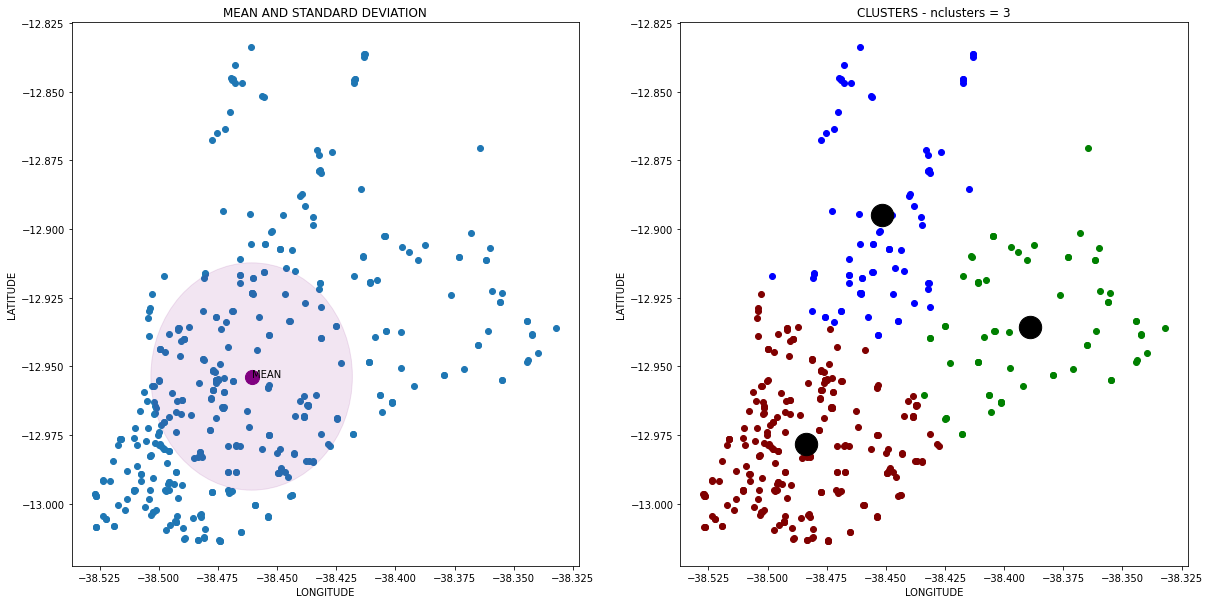

In [8]:
# para cada bairro na lista CSV_LIST repete:
for regionName, regionFile in CSV_LIST.items():
    # testa se o arquivo existe
    if os.path.isfile(regionFile) is False:
        print("> CSV da região '%s' não encontrado!"%(regionName))
        continue

    # Lê o arquivo csv com as coordenadas de entrada
    coords = pd.read_csv(regionFile)
    # separa os vetores de latitude e longitude
    lat = coords['Latitude']
    longi = coords['Longitude']
    # empilha a matriz de coordenadas em um numpy array
    coords = np.column_stack((longi, lat))

    # calcula a mediana do conjunto de coordenadas
    coords_mean = np.mean(coords, 0)
    # calcula o desvio padrão das coordenadas
    coords_std = np.std(coords, 0) 
    # calcula a mediana da elipse circunscrita
    ellipse_mean = patches.Ellipse([coords_mean[0], coords_mean[1]], coords_std[0]*2, coords_std[1]*2, color = 'purple', alpha = 0.1)

    # encontra os NCLUSTERS para o conjunto de coordenadas
    clusters, clindexes = findClusters(coords, NCLUSTERS)

    # imprime as coordenadas dos clusters em uma tabela
    printClusterCoords(clusters, regionName)
    

    # plota em gráficos 2D
    plotClusterCharts(coords, coords_mean, ellipse_mean, clusters,
    clindexes, NCLUSTERS, regionName)

    # cria um mapa e desenha os clusters e coordenadas nele
    mymap = drawOnMap(MAP_CENTER[0], MAP_CENTER[1], coords, clusters, clindexes, NCLUSTERS)
    
    # salva o mapa em um arquivo HTML
    mapFile = "tmp/gasmap_%s.html"%(regionName)
    mymap.save(mapFile)

    # exibe
    display(mymap)
